In [ ]:
# !pip install -U sentence-transformers
# !pip install -U transformers
# import nltk
# nltk.download('wordnet')
# nltk.download('omw-1.4')

In [1]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sentence_transformers import SentenceTransformer, util
from gensim.parsing.preprocessing import remove_stopwords
from gensim.corpora.dictionary import Dictionary
from sklearn.neighbors import NearestNeighbors
from nltk.corpus import wordnet as wn
from matplotlib import pyplot as plt
from gensim.models import LdaModel
import pickle
import os

In [2]:
X = []
y = []

for word in wn.all_synsets():
    # e.g. Synset('able.a.01')
    X.append(word.definition())
    y.append(word.name().split('.')[0])

num of words: 86555
num of docs: 117659
max doc length: 82
min doc length: 1


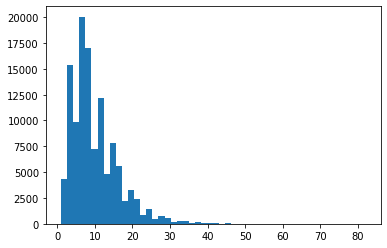

In [3]:
l = [len(i.split()) for i in X]
print(f'num of words: {len(set(y))}')
print(f'num of docs: {len(X)}')
print(f'max doc length: {max(l)}')
print(f'min doc length: {min(l)}')

plt.hist(l, bins=50)
plt.show()

# 1. TF-IDF + KNN

In [4]:
# https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html
tfidf_vectorizer = TfidfVectorizer()
X_tfidf = tfidf_vectorizer.fit_transform(X)
print(X_tfidf.shape)

(117659, 44399)


In [5]:
query = 'a road that car can go through quickly'
# query = 'a place can hold patients'
# query = 'a place had a lot of books'
# query = 'a food tastes good'
# query = 'very beautiful'

query = tfidf_vectorizer.transform([query])

knn = NearestNeighbors(n_neighbors=10)
knn.fit(X_tfidf)

nbrs = knn.kneighbors(query, return_distance=False)[0]
for i in nbrs:
    word = y[i]
    score = util.dot_score(X_tfidf[i].toarray(), query.toarray()).item()
    print(f'({word:<15}, {round(score,3)})')

(pass           , 0.404)
(experience     , 0.4)
(quicker        , 0.374)
(short-order    , 0.365)
(whip_through   , 0.362)
(quickest       , 0.357)
(roadway        , 0.355)
(short_order    , 0.353)
(blow           , 0.35)
(douse          , 0.349)


In [6]:
# counter-example can be written in report
X[y.index('junk_food')]

'food that tastes good but is high in calories having little nutritional value'

# 2. LDA + KNN

In [7]:
# https://radimrehurek.com/gensim/models/ldamodel.html
NUM_TOPICS = 50 

data_lda = [remove_stopwords(x).split() for x in X]
dict_lda = Dictionary(data_lda)
corpus_lda = [dict_lda.doc2bow(doc) for doc in data_lda]
lda = LdaModel(corpus_lda, NUM_TOPICS, dict_lda, random_state=0)

In [8]:
X_lda = []
for doc in lda.get_document_topics(corpus_lda, minimum_probability=0):
    X_lda.append([score for _, score in doc])
print(f'({len(X_lda)}, {len(X_lda[0])})')

(117659, 50)


In [9]:
X_lda[0]

[0.0025000358,
 0.0025000358,
 0.0025000358,
 0.0025000358,
 0.25250134,
 0.0025000358,
 0.0025000358,
 0.0025000358,
 0.3774979,
 0.0025000358,
 0.0025000358,
 0.0025000358,
 0.0025000358,
 0.0025000358,
 0.0025000358,
 0.0025000358,
 0.0025000358,
 0.0025000358,
 0.0025000358,
 0.0025000358,
 0.0025000358,
 0.0025000358,
 0.0025000358,
 0.0025000358,
 0.12749797,
 0.0025000358,
 0.0025000358,
 0.0025000358,
 0.0025000358,
 0.0025000358,
 0.0025000358,
 0.0025000358,
 0.0025000358,
 0.12750113,
 0.0025000358,
 0.0025000358,
 0.0025000358,
 0.0025000358,
 0.0025000358,
 0.0025000358,
 0.0025000358,
 0.0025000358,
 0.0025000358,
 0.0025000358,
 0.0025000358,
 0.0025000358,
 0.0025000358,
 0.0025000358,
 0.0025000358,
 0.0025000358]

In [10]:
lda.show_topic(8, topn=20)

[('condition', 0.16595136),
 ('means', 0.11573161),
 ('central', 0.080407344),
 ('normal', 0.05976753),
 ('space', 0.05214628),
 ('serve', 0.04308497),
 ('nervous', 0.0267681),
 ('necessary', 0.023836432),
 ('rain', 0.02318721),
 ('outside', 0.017841544),
 ('focus', 0.01575522),
 ('ends', 0.015530254),
 ('brief', 0.012296792),
 ('periods', 0.0113102645),
 ('visual', 0.0085783545),
 ('skill', 0.008544227),
 ('retina', 0.00563906),
 ('energetic', 0.004313839),
 ('images', 0.0030257863),
 ('determination', 0.0025905278)]

In [11]:
knn = NearestNeighbors(n_neighbors=10)
knn.fit(X_lda)

query = 'a road that car can go through quickly'
# query = 'a place can hold patients'
# query = 'a place had a lot of books'
# query = 'a food tastes good'
# query = 'very beautiful'

query = dict_lda.doc2bow(query.split())
query = lda.get_document_topics(query, minimum_probability=0)
query = [q for _,q in query]

nbrs = knn.kneighbors([query], return_distance=False)[0]
for i in nbrs:
    word = y[i]
    score = util.dot_score(X_lda[i], query).item()
    print(f'({word:<15}, {round(score,3)})')

(shy            , 0.265)
(whisk          , 0.265)
(run_up         , 0.265)
(allegro        , 0.265)
(whisk          , 0.265)
(whip_up        , 0.265)
(abruptly       , 0.265)
(dash_off       , 0.265)
(deluge         , 0.265)
(fried_rice     , 0.265)


In [12]:
query

[0.010000033,
 0.010000033,
 0.010000033,
 0.010000033,
 0.010000033,
 0.010000033,
 0.010000033,
 0.010000033,
 0.010000033,
 0.010000033,
 0.010000033,
 0.010000033,
 0.010000033,
 0.010000033,
 0.010000033,
 0.010000033,
 0.010000033,
 0.010000033,
 0.010000033,
 0.010000033,
 0.010000033,
 0.010000033,
 0.010000033,
 0.010000033,
 0.010000033,
 0.010000033,
 0.010000033,
 0.010000033,
 0.010000033,
 0.010000033,
 0.010000033,
 0.010000033,
 0.010000033,
 0.010000033,
 0.010000033,
 0.010000033,
 0.010000033,
 0.010000033,
 0.010000033,
 0.010000033,
 0.010000033,
 0.010000033,
 0.010000033,
 0.010000033,
 0.010000033,
 0.010000033,
 0.010000033,
 0.5099984,
 0.010000033,
 0.010000033]

# 3. BERT + KNN

In [13]:
# https://github.com/UKPLab/sentence-transformers
model = SentenceTransformer('multi-qa-MiniLM-L6-cos-v1')

In [14]:
if os.path.exists('embeds.pkl'):
    with open('embeds.pkl', 'rb') as f:
        data = pickle.load(f)
else:
    X_embed = [model.encode(x) for x in X]
    data = {'X_embed': X_embed,'y': y}
    with open('embeds.pkl', 'wb') as f:
        pickle.dump(data, f)

In [15]:
X_embed = data['X_embed']
y       = data['y']

knn = NearestNeighbors(n_neighbors=30)
knn.fit(X_embed)

query = model.encode("a road that car can't go through quickly")
# query = model.encode('a place can hold patients')
# query = model.encode('a place had a lot of books')
# query = model.encode('a food tastes not good')
# query = model.encode('not beautiful')
# query = model.encode('')

nbrs = knn.kneighbors([query], return_distance=False)[0]
for i in nbrs:
    word = y[i]
    score = util.dot_score(X_embed[i], query).item()
    print(f'({word:<15}, {round(score,3)})')

(roadway        , 0.705)
(speedway       , 0.698)
(slow_lane      , 0.659)
(highroad       , 0.646)
(access_road    , 0.644)
(fast_lane      , 0.643)
(clearway       , 0.633)
(expressway     , 0.618)
(turn_in        , 0.617)
(lane           , 0.615)
(rally          , 0.606)
(single-lane    , 0.602)
(beltway        , 0.596)
(track          , 0.593)
(detour         , 0.592)
(drive          , 0.592)
(turnout        , 0.588)
(blind_curve    , 0.58)
(one-way_street , 0.576)
(blind_corner   , 0.569)
(driveway       , 0.568)
(motorist       , 0.567)
(gridlock       , 0.566)
(divided_highway, 0.565)
(racer          , 0.56)
(draw_up        , 0.555)
(traffic_cop    , 0.555)
(whip_through   , 0.551)
(frontage_road  , 0.55)
(two-way_street , 0.55)
